In [136]:
import cirq
import numpy as np
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma, show_bloqs
from typing import *
import sympy
from qualtran import SoquetT
from qualtran.symbolics import SymbolicFloat, SymbolicInt
from qualtran.bloqs.basic_gates import CNOT, Hadamard, Rz, SGate, Ry, CZ, Rx, Swap
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientUnitary
from qualtran.bloqs.qft import QFTTextBook
from qualtran.cirq_interop.t_complexity_protocol import t_complexity
from qualtran.cirq_interop import BloqAsCirqGate
from qualtran.resource_counting import BloqCount
import attrs

To begin I implemented, displayed and cost estimated the individual circuits shown on the paper using Qualtran bloqs.

In [137]:
@attrs.frozen
class trial_state(Bloq): 
    N : int = 4 
    theta: float= 1
    phi: float = 1
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        eps = 1e-9 
        ys = bb.split(y)
       
        for i in range(self.N):
            ys[i] = bb.add(Ry(self.theta,eps),q=ys[i])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])

        ys[2] = bb.add(Ry(self.phi,eps),q=ys[2])
        ys[3] = bb.add(Ry(self.phi,eps),q=ys[3])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])
        
        y = bb.join(ys)
    
        return {'y': y}

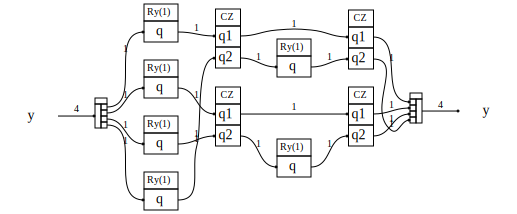

T-count:   0
Rotations: 6
Cliffords: 4



In [138]:
show_bloq(trial_state().decompose_bloq())
print(t_complexity(trial_state()))

In [139]:
@attrs.frozen
class symmetric_trial_state(Bloq): 
    N : int = 4 
    theta: float= 1
    phi: float = 1
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        eps = 1e-9 
        ys = bb.split(y)
       
        for i in range(self.N):
            ys[i] = bb.add(Ry(self.theta,eps),q=ys[i])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])

        for i in range(self.N):
            ys[i] = bb.add(Ry(self.phi/2,eps),q=ys[i])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])
        
        y = bb.join(ys)
    
        return {'y': y}

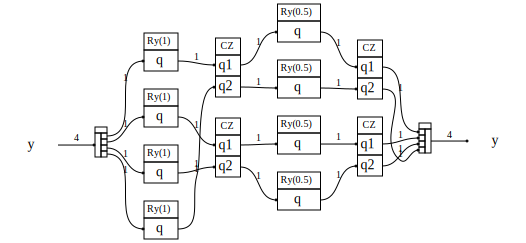

T-count:   0
Rotations: 8
Cliffords: 4



In [140]:
show_bloq(symmetric_trial_state().decompose_bloq())
print(t_complexity(symmetric_trial_state()))

In [141]:
@attrs.frozen
class first_implementation_circuit(Bloq): 
    N : int = 4 
    t: float= 1
    tau: float = 1
    U: float = 1
    eps: SymbolicFloat = 1e-9
    theta1: float = 4*t*tau
    theta2: float = tau*U/2

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        ys = bb.split(y)
       
        ys[0], ys[2] = bb.add(CNOT(),ctrl=ys[0], target=ys[2])
        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[0], target=ys[3])

        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[1], target=ys[2])
        
        ys[2]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[2]) 
        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 

        ys[0], ys[2] = bb.add(CNOT(),ctrl=ys[0], target=ys[2])
        ys[1], ys[3] = bb.add(CNOT(),ctrl=ys[1], target=ys[3])

        ys[2]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[2]) 
        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 

        ys[2], ys[3] = bb.add(CNOT(),ctrl=ys[2], target=ys[3])

        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 
        
        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[0], target=ys[3])
        ys[1], ys[3] = bb.add(CNOT(),ctrl=ys[1], target=ys[3])

        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 
        
        ys[2], ys[3] = bb.add(CNOT(),ctrl=ys[2], target=ys[3])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[1], target=ys[2])

        for i in range(self.N):
            ys[i] = bb.add(Rx(self.theta1,self.eps),q=ys[i])


        
        y = bb.join(ys)
    
        return {'y': y}

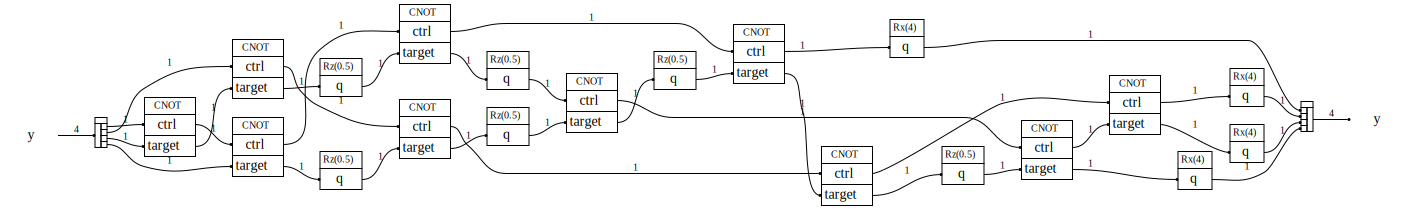

T-count:   0
Rotations: 10
Cliffords: 10



In [142]:
show_bloq(first_implementation_circuit().decompose_bloq())
print(t_complexity(first_implementation_circuit()))

In [143]:
@attrs.frozen
class second_implementation_circuit(Bloq): 
    N : int = 4 
    t: float= 1
    tau: float = 1
    U: float = 1
    eps: SymbolicFloat = 1e-9
    theta1: float = 4*t*tau
    theta2: float = tau*U/2

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        ys = bb.split(y)

        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])

        ys[0] = bb.add(Rz(self.theta2, eps=self.eps),q=ys[0]) 
        ys[1]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[1]) 

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])

        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[3], target=ys[0])
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])

        ys[0] = bb.add(Rz(self.theta2, eps=self.eps),q=ys[0]) 
        ys[1]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[1]) 

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])

        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[3], target=ys[0])   #check what's happening with the rectange highlighted by the paper
        ys[1], ys[2] = bb.add(Swap(1), x=ys[1], y=ys[2])

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])
        ys[0] = bb.add(Rz(self.theta2, eps=self.eps),q=ys[0]) 

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])

        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[3], target=ys[0])
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])
        ys[1]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[1]) 
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])

        for i in range(self.N):
            ys[i] = bb.add(Rx(self.theta1,self.eps),q=ys[i])


        
        y = bb.join(ys)
    
        return {'y': y}

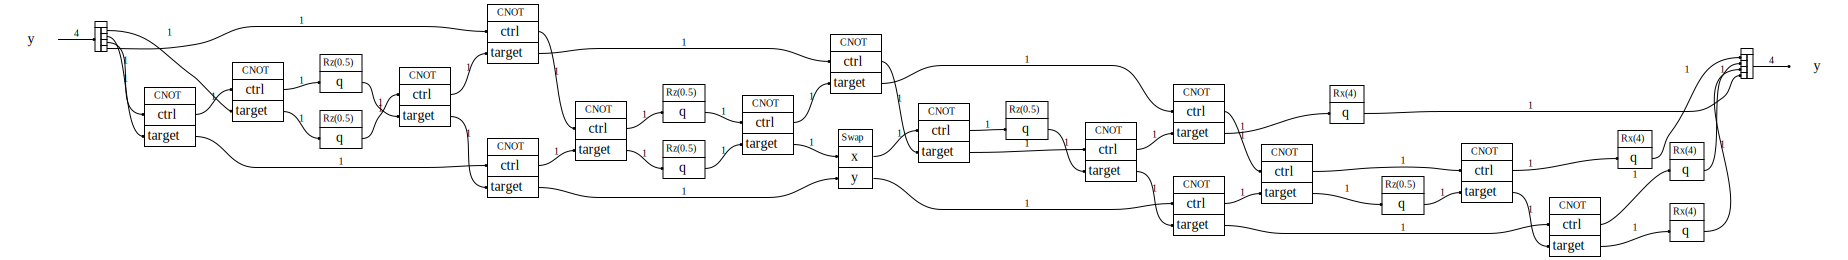

T-count:   0
Rotations: 10
Cliffords: 16



In [144]:
show_bloq(second_implementation_circuit().decompose_bloq())
print(t_complexity(second_implementation_circuit()))


Following is a test on getting a working conversion from a Qualtran bloq to a cirq circuit where I can run an actual simulation.

In [145]:
cirq_first_implementation = first_implementation_circuit().as_composite_bloq().to_cirq_circuit()
op = next(cirq_first_implementation.all_operations())

first_imp_decomp_circuit = cirq.Circuit(cirq.decompose_once(op))
print(first_imp_decomp_circuit)

           ┌──┐                ┌──┐
y0: ───@────@───────────────────@───────────────────────────────────@───Rx(1.27π)────────────────────────────────────────────
       │    │                   │                                   │
y1: ───┼────┼@──────────────────┼@──────────────────────────────────┼───@────────────────────────────@───────────Rx(1.27π)───
       │    ││                  ││                                  │   │                            │
y2: ───X────┼X────Rz(0.159π)────X┼────Rz(0.159π)───@────────────────┼───┼────────────────────────@───X───────────Rx(1.27π)───
            │                    │                 │                │   │                        │
y3: ────────X─────Rz(0.159π)─────X────Rz(0.159π)───X───Rz(0.159π)───X───X───────────Rz(0.159π)───X───Rx(1.27π)───────────────
           └──┘                └──┘


In [146]:
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(first_imp_decomp_circuit)
print(results)
wf =  s.simulate(first_imp_decomp_circuit).final_state_vector
print(wf)

# For sampling, we need to add a measurement at the end
first_imp_decomp_circuit.append(cirq.measure(cirq.NamedQubit('y0'),cirq.NamedQubit('y1'),cirq.NamedQubit('y2'),cirq.NamedQubit('y3'),key='result'))
print(first_imp_decomp_circuit)

# Sample the circuit
samples = s.run(first_imp_decomp_circuit, repetitions=1000)


Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.NamedQubit('y1'), cirq.NamedQubit('y0'), cirq.NamedQubit('y2'), cirq.NamedQubit('y3'))
output vector: [ 0.00212146-0.02991556j  0.06536669+0.00463547j  0.06536669+0.00463547j
 -0.01012868+0.1428288j   0.06536669+0.00463547j -0.01012868+0.14282882j
 -0.01012868+0.1428288j  -0.31208667-0.02213157j  0.06536669+0.00463547j
 -0.01012868+0.14282882j -0.01012868+0.1428288j  -0.31208667-0.02213157j
 -0.01012868+0.14282882j -0.31208664-0.02213157j -0.31208667-0.02213157j
  0.04835836-0.6819217j ]

phase:
output vector: |⟩
[ 0.00212146-0.02991556j  0.06536669+0.00463547j  0.06536669+0.00463547j
 -0.01012868+0.1428288j   0.06536669+0.00463547j -0.01012868+0.14282882j
 -0.01012868+0.1428288j  -0.31208667-0.02213157j  0.06536669+0.00463547j
 -0.01012868+0.14282882j -0.01012868+0.1428288j  -0.31208667-0.02213157j
 -0.01012868+0.14282882j -0.31208664-0.02213157j -0.31208667-0.02213157j
  0.04835836-0.6819217j ]
           ┌──┐      

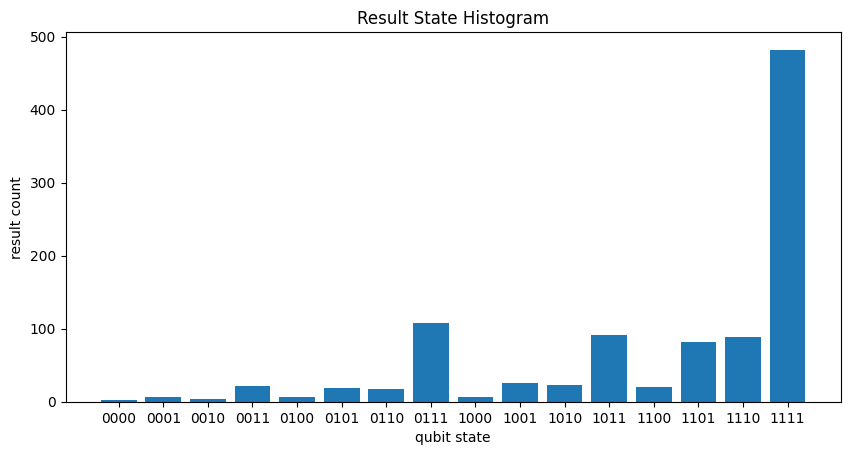

In [147]:
import matplotlib.pyplot as plt

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2 ** num_qubits)]
f = plt.figure()
cirq.plot_state_histogram(samples, plt.subplot(), tick_label=binary_labels(4))
f.set_figwidth(10)
plt.show()

Following, I will attempt the state initialization optimization procedure shown on the paper using cirq and compare the number of runs needed to the result from the paper.

In [148]:
def trial_state_circ(theta,phi):

    cirq_trial_state = trial_state(theta=theta,phi=phi).as_composite_bloq().to_cirq_circuit()
    op = next(cirq_trial_state.all_operations())

    trial_state_eval = cirq.Circuit(cirq.decompose_once(op))
    print(trial_state_eval)
    yield trial_state_eval


print(trial_state_circ(theta=1,phi=1))

<generator object trial_state_circ at 0x7f9541f69b70>


The goal of the implementation is to minimize the energy and get the ground state. For this I need to define the simplified Hamiltonian used for this toy model.

In [149]:
# The functions take a list of the qubits X or Z is acting on and produces the corresponding X or Z resulting matrix
def Z_4q(qubit):
    n_qubits=4
    Z1 = [[1,0],[0,-1]]
    Z = 1
    for i in range(0,n_qubits):
        if i in qubit:
            mat=Z1
        else: 
            mat=np.identity(2)
        Z = np.kron(Z,mat)
    return Z



def X_4q(qubit):
    n_qubits=4
    X1 = [[0,1],[1,0]] 
    X = 1
    for i in range(0,n_qubits):
        if i in qubit:
            mat=X1
        else: 
            mat=np.identity(2)
        X = np.kron(X,mat)
    return X



In [150]:
t = 1.0
U = -7.0
V = 35

def simpl_energy_from_wavefunction(wf):
    """wf: array input with wavefunction info"""
    n_qubits = 4
    n_states = 2**n_qubits

    X_term_mat = np.zeros([n_states,n_states])

    for i in range(n_qubits):
        X_term_mat += X_4q([i])

    ZZ_term_mat= Z_4q([0,3]) + Z_4q([1,2])
   
    ZZZ_term_mat = np.zeros([n_states,n_states])

    for i in range(n_qubits):
        for j in range(i+1,n_qubits-1):
            for k in range(j+1,n_qubits):
                ZZZ_term_mat += Z_4q([i,j,k])

    X_term = np.inner(np.conj(wf).T,np.matmul(X_term_mat,wf))
    ZZ_term = np.inner(np.conj(wf).T,np.matmul(ZZ_term_mat,wf))
    ZZZ_term = np.inner(np.conj(wf).T,np.matmul(ZZZ_term_mat,wf))
    
    E_1 = (8*t + U/2)

    E_2 = X_term*(-2*t) 
     
    E_3 = ZZ_term * (-1*U/4)
        
    E_4 = ZZZ_term * (-1*U/4)

    Energy = E_1 + E_2 + E_3 + E_4

    exp_val = np.real(np.sum(Energy))
    return exp_val

simpl_energy_from_wavefunction(wf)

4.040490775158967

In [151]:
def energy_from_wavefunction(wf):
    """wf: array input with wavefunction info"""
    n_qubits = 4
    n_states = 2**n_qubits

    X_term_mat = np.zeros([n_states,n_states])

    for i in range(n_qubits):
        X_term_mat += X_4q([i])

    Z_term_mat = np.zeros([n_states,n_states])

    for i in range(n_qubits):
        Z_term_mat += Z_4q([i])

    ZZ_term_mat1= Z_4q([0,3]) + Z_4q([1,2])
    ZZ_term_mat2= Z_4q([0,1]) + Z_4q([0,2]) + Z_4q([1,3]) + Z_4q([2,3])
   
    ZZZ_term_mat = np.zeros([n_states,n_states])

    for i in range(n_qubits):
        for j in range(i+1,n_qubits-1):
            for k in range(j+1,n_qubits):
                ZZZ_term_mat += Z_4q([i,j,k])
    
    ZZZZ_term_mat = Z_4q([0,1,2,3])

    X_term = np.inner(np.conj(wf).T,np.matmul(X_term_mat,wf))
    Z_term = np.inner(np.conj(wf).T,np.matmul(Z_term_mat,wf))
    ZZ_term1 = np.inner(np.conj(wf).T,np.matmul(ZZ_term_mat1,wf))
    ZZ_term2 = np.inner(np.conj(wf).T,np.matmul(ZZ_term_mat2,wf))
    ZZZ_term = np.inner(np.conj(wf).T,np.matmul(ZZZ_term_mat,wf))
    ZZZZ_term = np.inner(np.conj(wf).T,np.matmul(ZZZZ_term_mat,wf))

    
    E_1 = (8*t + U/2)

    E_2 = X_term*(-2*t) 

    E_3 = Z_term * ((4*U+V)/16)

    E_4 = ZZ_term1 * (V/16)

    E_5 = ZZ_term2 * ((4*U+V)/16)

    E_6 = ZZZ_term * (V/16)

    E_7 = ZZZZ_term * ((4*U+V)/16)

    Energy = E_1 + E_2 + E_3 + E_4 + E_5 + E_6 +E_7

    exp_val = np.real(np.sum(Energy))
    return exp_val

energy_from_wavefunction(wf)


3.609286907566966

In [152]:
import sympy
circuit = cirq.Circuit()
theta = sympy.Symbol('theta')
phi = sympy.Symbol('phi')
circuit.append(trial_state_circ(theta,phi))


                   ┌──┐             ┌──┐
y0: ───Ry(theta)────@────────────────@─────
                    │                │
y1: ───Ry(theta)────┼@───────────────┼@────
                    ││               ││
y2: ───Ry(theta)────┼@────Ry(phi)────┼@────
                    │                │
y3: ───Ry(theta)────@─────Ry(phi)────@─────
                   └──┘             └──┘


In [153]:
simulator = cirq.Simulator()

sweep_size = 50

sweep = (cirq.Linspace(key='theta', start=-np.pi, stop=np.pi, length=sweep_size)
         * cirq.Linspace(key='phi', start=-np.pi, stop=np.pi, length=sweep_size))
results = simulator.simulate_sweep(circuit, params=sweep, initial_state=None)

min = None
min_params = None
theta_vec = np.array([])
phi_vec = np.array([])
exp_val_vec = np.array([])
simpl_exp_val_vec = np.array([])

for result in results:
    wf = result.final_state_vector
    value = energy_from_wavefunction(wf)
    value_simpl = simpl_energy_from_wavefunction(wf)
    theta_vec= np.append(theta_vec,result.params['theta'])
    phi_vec= np.append(phi_vec,result.params['phi'])
    exp_val_vec =np.append(exp_val_vec,value)
    simpl_exp_val_vec =np.append(simpl_exp_val_vec,value_simpl)
    if min is None or value < min: 
        min = value
        min_params = result.params
print(f'Minimum objective value is {min}.')
print(min_params)


Minimum objective value is -4.594353894881872.
cirq.ParamResolver({'theta': 1.4746251231135767, 'phi': 0.4487989505128276})


Text(0.5, 1.0, 'Simplified Energy')

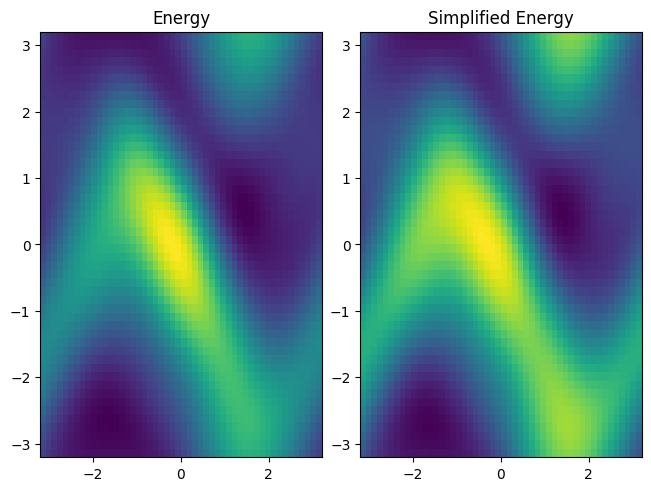

In [154]:
N = int(np.sqrt(len(theta_vec)))
x = theta_vec.reshape((N, N))
y = phi_vec.reshape((N, N))
z = exp_val_vec.reshape((N, N))
z2 = simpl_exp_val_vec.reshape((N, N))
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained')
ax1.pcolormesh(x,y,z)
ax1.set_title('Energy')
ax2.pcolormesh(x,y,z2)
ax2.set_title('Simplified Energy')

# fig.colorbar()

cirq.ParamResolver({'theta': 1.4746251231135767, 'phi': 0.4487989505128276})


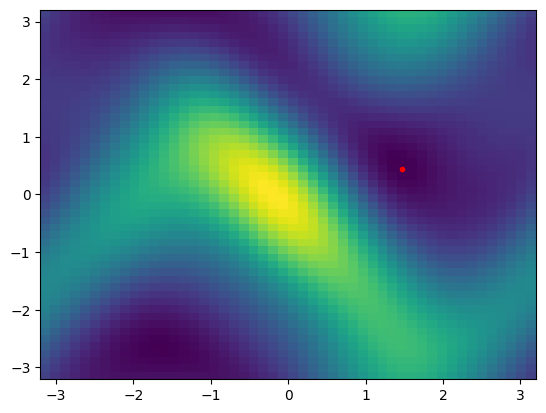

In [155]:
plt.pcolormesh(x,y,z)
plt.plot(min_params['theta'],min_params['phi'],'.r')
print(min_params)


In [156]:
def sym_trial_state_circ(theta,phi):

    cirq_trial_state = symmetric_trial_state(theta=theta,phi=phi).as_composite_bloq().to_cirq_circuit()
    op = next(cirq_trial_state.all_operations())

    trial_state_eval = cirq.Circuit(cirq.decompose_once(op))
    print(trial_state_eval)
    yield trial_state_eval

In [157]:
circuit2 = cirq.Circuit()

circuit2.append(sym_trial_state_circ(theta,phi))

                   ┌──┐               ┌──┐
y0: ───Ry(theta)────@─────Ry(phi/2)────@─────
                    │                  │
y1: ───Ry(theta)────┼@────Ry(phi/2)────┼@────
                    ││                 ││
y2: ───Ry(theta)────┼@────Ry(phi/2)────┼@────
                    │                  │
y3: ───Ry(theta)────@─────Ry(phi/2)────@─────
                   └──┘               └──┘


In [158]:
simulator = cirq.Simulator()

sweep_size = 50
sweep = (cirq.Linspace(key='theta', start=-np.pi, stop=np.pi, length=sweep_size)
         * cirq.Linspace(key='phi', start=-np.pi, stop=np.pi, length=sweep_size))
results = simulator.simulate_sweep(circuit2, params=sweep, initial_state=None)

min = None
min_params = None
theta_vec2 = np.array([])
phi_vec2 = np.array([])
exp_val_vec2 = np.array([])
for result in results:
    wf = result.final_state_vector
    value = energy_from_wavefunction(wf)
    theta_vec2= np.append(theta_vec2,result.params['theta'])
    phi_vec2= np.append(phi_vec2,result.params['phi'])
    exp_val_vec2 =np.append(exp_val_vec2,value)
    if min is None or value < min:
        min = value
        min_params2 = result.params
print(f'Minimum objective value is {min}.')
print(min_params2)

Minimum objective value is -4.596436317048782.
cirq.ParamResolver({'theta': -1.7310816662637638, 'phi': -2.628679567289419})


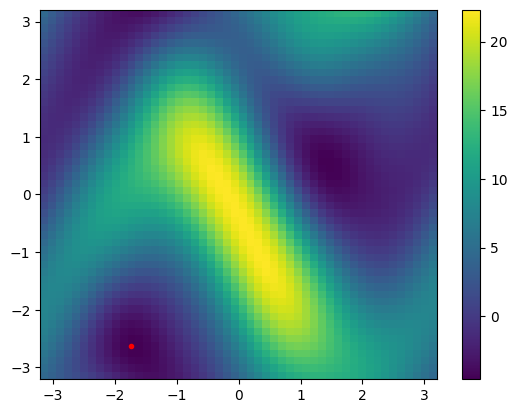

In [159]:
# plt.hist2d(theta_vec2,phi_vec2,weights=exp_val_vec2)
N = int(np.sqrt(len(theta_vec2))) 
x_sym = theta_vec2.reshape((N, N))
y_sym = phi_vec2.reshape((N, N))
z_sym = exp_val_vec2.reshape((N, N))

plt.pcolormesh(x_sym,y_sym,z_sym)
plt.plot(min_params2['theta'],min_params2['phi'],'.r')
plt.colorbar()

Text(0.5, 1.0, 'Trial State 2')

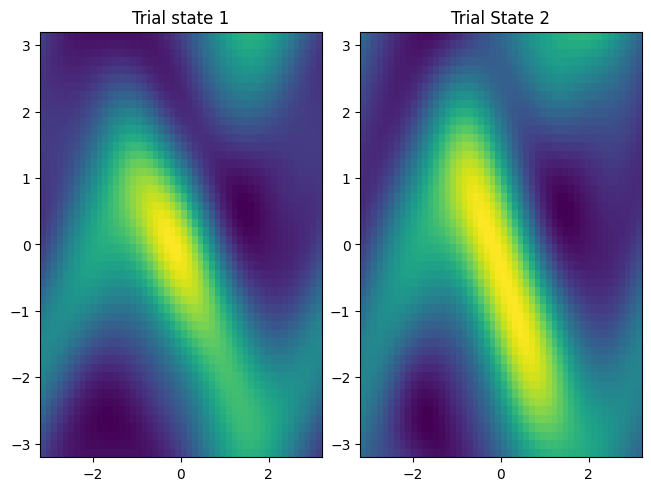

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained')
ax1.pcolormesh(x,y,z)
ax1.set_title('Trial state 1')
ax2.pcolormesh(x_sym,y_sym,z_sym)
ax2.set_title('Trial State 2')